# Langgraph 2

In [6]:
%run utilities.ipynb

# Graph with interrupt

https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787

https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/

Dieser Code definiert einen zustandsbasierten Ablauf für ein einfaches Programm mit Knoten, die verschiedene Phasen oder "Zustände" repräsentieren und in einem gerichteten Graphen organisiert sind. Hier ist eine detaillierte Erklärung:

### Hauptkomponenten

#### State-Klassendefinition

```python
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]
```

- **`State`-Klasse**: Definiert die Struktur des `state`-Dictionaries.  
    - **`input`**: Ein String, vermutlich für eine anfängliche Eingabe oder Benutzerdaten.
    - **`messages`**: Eine Liste, die mit `add_messages` annotiert ist. Dies scheint ein Hilfswerkzeug oder Dekorator zu sein, der beim Verwalten der Nachrichten in jedem Knoten hilft.

#### Knotenfunktionen

```python
def node1(state: State):
    print("Start node 1")
    state["messages"] = ["Output node1: Hello"]
    return state 
```

- **`node1`-Funktion**: Initialisiert den ersten Knoten im Zustandsgraphen.
    - Gibt eine Nachricht aus, dass Knoten 1 gestartet wurde.
    - Setzt `state["messages"]` auf `["Output node1: Hello"]`.
    - Gibt den geänderten `state` zurück.

Jede nachfolgende Knotenfunktion, `node2` und `node3`, funktioniert ähnlich:

```python
def node2(state: State):
    print("Start node2")
    state["messages"] = ["Output node2: And now?"]
    return state 

def node3(state: State):
    print("---node3---")
    state["messages"] = ["node3: The end"]
    return state 
```

- **Zusammenfassung der Knotenfunktionen**:
    - `node2` aktualisiert die Nachricht auf "Output node2: And now?"
    - `node3` aktualisiert die Nachricht auf "node3: The end."

#### Graph-Definition

```python
builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.set_entry_point("node1")
builder.add_edge("node1", "node2")
builder.add_edge("node2", "node3")
builder.add_edge("node3", END)
```

- **Graph-Builder**: Erstellt einen gerichteten Graphen, um die Knoten in Reihenfolge zu organisieren.
    - Initialisiert den `StateGraph` mit der `State`-Datenstruktur.
    - Fügt die Knoten `node1`, `node2` und `node3` hinzu.
    - Legt `node1` als Einstiegspunkt fest.
    - Verbindet die Knoten in einer Reihenfolge und endet mit `END` nach `node3`, was wahrscheinlich das Ende des Graphen darstellt.

#### Zusätzliche Einrichtung

```python
memory = MemorySaver()
graph = builder.compile(checkpointer=memory, interrupt_before=["node3"])
```

- **Speicherverwaltung**: Richtet eine Speicherverwaltung mit `MemorySaver` ein, um Zustandsänderungen zu verfolgen.
- **Kompilierung**: Kompiliert den Graphen und setzt einen Checkpoint bei jedem Zustand, wobei eine Unterbrechung vor `node3` erfolgt.

#### Graph-Visualisierung

```python
display(Image(graph.get_graph().draw_mermaid_png()))
```

- **Visualisierung**: Der Code visualisiert den Graphen mit Mermaid und zeigt jeden Knoten und dessen gerichtete Kanten an.

### Zusammenfassung

Dieser Code definiert eine zustandsbasierte Graphstruktur, in der `node1`, `node2` und `node3` aufeinanderfolgende Zustände mit Nachrichten darstellen. Der `StateGraph` erstellt einen gerichteten Graphen, bei dem jeder Knoten den `state` ändert und Daten an den nächsten Knoten weitergibt. Die Komponenten zur Speicherverwaltung und Graphvisualisierung bieten eine Nachverfolgung und Darstellung der Struktur und des Ablaufs des Graphen. Dies ist ein einfaches Beispiel für den Aufbau und die Visualisierung zustandsbasierter Workflows in einem Programm.

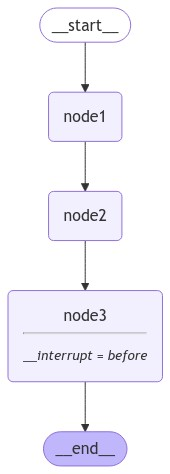

In [7]:
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]


def node1(state:State):
    print("Start node 1")
    state["messages"]=["Output node1: Hello"]
    return state 


def node2(state:State):
    print("Start node2")
    state["messages"]=["Output node2: And now?"]
    return state 



def node3(state:State):
    print("---node3---")
    state["messages"]=["node3: The end"]
    return state 



builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.set_entry_point("node1") 
builder.add_edge("node1", "node2")
builder.add_edge("node2", "node3")
builder.add_edge("node3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory,interrupt_before=["node3"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Der Graph wird bis zum Node 2 ausgeführt 

In [8]:
thread = {"configurable": {"thread_id": "1"}}
state=State()
initial_input = {"input": "hello world"}
for state in graph.stream(initial_input, thread, stream_mode="values"):
    print(state)


{'input': 'hello world', 'messages': []}
Start node 1
{'input': 'hello world', 'messages': [HumanMessage(content='Output node1: Hello', additional_kwargs={}, response_metadata={}, id='a695c722-b4b1-40c6-a63f-62d397116496')]}
Start node2
{'input': 'hello world', 'messages': [HumanMessage(content='Output node1: Hello', additional_kwargs={}, response_metadata={}, id='a695c722-b4b1-40c6-a63f-62d397116496'), HumanMessage(content='Output node2: And now?', additional_kwargs={}, response_metadata={}, id='3020b13d-4473-4a92-9b26-b0b57e736a57')]}


## Der Graph wird weiter ausgeführt wegen input=none

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)    


{'input': 'hello world', 'messages': [HumanMessage(content='Output node1: Hello', additional_kwargs={}, response_metadata={}, id='a695c722-b4b1-40c6-a63f-62d397116496'), HumanMessage(content='Output node2: And now?', additional_kwargs={}, response_metadata={}, id='3020b13d-4473-4a92-9b26-b0b57e736a57')]}
---node3---
{'input': 'hello world', 'messages': [HumanMessage(content='Output node1: Hello', additional_kwargs={}, response_metadata={}, id='a695c722-b4b1-40c6-a63f-62d397116496'), HumanMessage(content='Output node2: And now?', additional_kwargs={}, response_metadata={}, id='3020b13d-4473-4a92-9b26-b0b57e736a57'), HumanMessage(content='node3: The end', additional_kwargs={}, response_metadata={}, id='4794dfcb-af3e-44e4-8319-4dd4ceffd970')]}


In [23]:
state=State()
state["input"]="wassuup"
state=graph.invoke(state,thread)

Start node 1
Start node2


## Panel mit widget für  user input

Dieser Code erstellt eine interaktive Benutzeroberfläche, in der der Benutzer:

1. Eine Frage im Texteingabefeld eingeben kann.
2. Den „Answer“-Button klicken kann, um die Eingabe abzusenden.
3. Die Eingabe wird durch einen `graph` gestreamt, und die Antwort wird in Echtzeit im Ausgabefeld angezeigt.

Dieses Setup ist besonders nützlich für Workflows, die eine Echtzeit-Rückmeldung erfordern, da die Eingabe Schritt für Schritt durch eine `graph`-Struktur verarbeitet wird.

In [10]:
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text

# Function to handle input and update the output

def input_function(event):
    if question.value:
        input = {"input": question.value}
    else:
        input=None
    print("input",input)
    out=[]
### Graph continues if input=none
    for state in graph.stream(input, thread, stream_mode="values"):
        out.append(state["messages"][-1].content)
    for state in graph.stream(None, thread, stream_mode="values"):
        out.append(state["messages"][-1].content)  

    answer="Hint:graph continues if input is empty! "+ "\n".join(out)
    output.object = f"**Answer:**\n\n{answer}"  # Update output with the answer

# Set up the answer button and bind the function
answer_button = pn.widgets.Button(name="Answer", button_type="primary")
answer_button.on_click(input_function)

# Layout with question input, answer button, and output display
Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()


Launching server at http://localhost:59225


input {'input': 'hi'}
Start node 1
Start node2
{'input': 'hi', 'messages': [HumanMessage(content='Output node1: Hello', additional_kwargs={}, response_metadata={}, id='a695c722-b4b1-40c6-a63f-62d397116496'), HumanMessage(content='Output node2: And now?', additional_kwargs={}, response_metadata={}, id='3020b13d-4473-4a92-9b26-b0b57e736a57'), HumanMessage(content='node3: The end', additional_kwargs={}, response_metadata={}, id='4794dfcb-af3e-44e4-8319-4dd4ceffd970'), HumanMessage(content='Output node1: Hello', additional_kwargs={}, response_metadata={}, id='0ac8b217-1c5a-4bf0-b53d-0fcb140c5d23'), HumanMessage(content='Output node2: And now?', additional_kwargs={}, response_metadata={}, id='d02c7dbf-a6d5-4399-aea0-7c370835a98f')]}
---node3---
{'input': 'hi', 'messages': [HumanMessage(content='Output node1: Hello', additional_kwargs={}, response_metadata={}, id='a695c722-b4b1-40c6-a63f-62d397116496'), HumanMessage(content='Output node2: And now?', additional_kwargs={}, response_metadata={}

# Exercise

a)Lassen Sie die App laufen so dass der Graph einschliesslich bis node 3 ausgeführt wird. 

b) Verwenden Sie

for state in graph.stream(None, thread, stream_mode="values"):
        out.append(state["messages"][-1].content)  

um den Graphen bis zum node 3 weiter auszuführen.

## Solution

In [12]:
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text

# Function to handle input and update the output

def input_function(event):
    input = {"input": question.value}
    print("input",input)
    out=[]

    for state in graph.stream(input, thread, stream_mode="values"):
        out.append(state["messages"][-1].content)
    for state in graph.stream(None, thread, stream_mode="values"):
        out.append(state["messages"][-1].content)  

    answer="Graph continued"+ "\n".join(out)
    output.object = f"**Answer:**\n\n{answer}"  # Update output with the answer

# Set up the answer button and bind the function
answer_button = pn.widgets.Button(name="Answer", button_type="primary")
answer_button.on_click(input_function)

# Layout with question input, answer button, and output display
Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()


Launching server at http://localhost:59300


input {'input': 'hello'}
Start node 1
Start node2
---node3---


# Conditional edge and interrupt

Dieser Code erstellt einen **Zustandsgraphen** mit bedingten Übergängen zwischen den Knoten und speichert den Verlauf im Speicher:

1. **Zustandsklasse**: Die Klasse `State` enthält die Eingabe (`input`) und eine Liste von Nachrichten (`messages`).

2. **Knotenfunktionen**: Drei Funktionen (`node1`, `node2`, `node3`) definieren die Aktionen in jedem Knoten. 
   - `node1`: Gibt nur eine Nachricht aus.
   - `node2` und `node3`: Setzen Nachrichtenwerte im Zustand auf ihren Knoten-Namen.

3. **Bedingte Übergänge**:
   - Die Funktion `should_continue` überprüft den letzten Nachrichteninhalt:
     - Falls die Nachricht "node1" ist, leitet sie zu `"node2"` weiter.
     - Andernfalls wechselt sie zu `"node3"`.

4. **Graphenerstellung**:
   - Der `StateGraph` beginnt bei `node1`.
   - Bedingte Kanten werden hinzugefügt: von `node1` zu `node2` oder `node3`, abhängig von `should_continue`.
   - Der Graph enthält auch eine Verbindung von `node2` zurück zu `node1` und von `node3` zu `END`.

5. **Speicher und Unterbrechung**: Ein `MemorySaver` speichert den Ablauf, und nach `node1` ist eine Unterbrechung vorgesehen.

6. **Visualisierung**: Der Graph wird als Mermaiddiagramm angezeigt.

Dieser Graph erlaubt es dem Agenten, basierend auf Nachrichteninhalt zwischen den Knoten zu wechseln und den Zustand nachzuverfolgen.

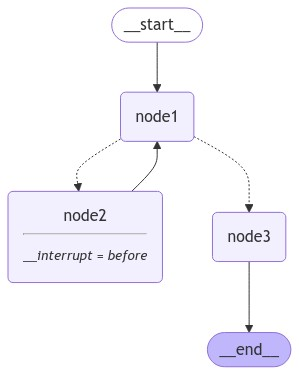

In [3]:
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]


def node1(state:State):
    print("Inside node 1")
    return state 


def node2(state:State):
    print("Inside node2")
    state["messages"]=["inside node2"]
    return state 



def node3(state:State):
    print("Inside node3")
    state["messages"]=["inside node3"]
    return state 


def should_continue(state:State):
    messages = state['messages']
    last_message = messages[-1]
    print("should_continue,last_message",last_message)
    # If the LLM makes a tool call, then we route to the "tools" node
    
    if last_message.content=="go to node2":
        print("continue to:","node2")
        return "node2"
    # Otherwise, we stop (reply to the user)
    else:
        print("continue to:","node3")
        return "node3"


builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.set_entry_point("node1") 


builder.add_conditional_edges(
    "node1",
    should_continue,
    {"node3": "node3", "node2": "node2"},
    )        

builder.add_edge("node2", "node1")

builder.add_edge("node3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory,interrupt_before=["node2"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
thread = {"configurable": {"thread_id": "1"}}
state=State()
state["messages"]=""
# Invoke the graph to process the user input
state = graph.invoke(state, thread)

Inside node 1
should_continue,last_message content='' additional_kwargs={} response_metadata={} id='66ebaad5-260e-4189-8031-12eae00438e9'
continue to: node2


# Exercise

1.Geben Sie den User Input so ein, dass der Graph zuerst zu node 2 geht.

2.Geben Sie den User Input so ein, dass der Graph gleich zu node 3 geht.

3.Ändern Sie den Graphen so, dass solange node2 ausgefürht wird bis "go to node3" eingegeben wird


In [8]:
# Get user input, replace this with widget
try:
    user_input = input("what next?")
except:
    user_input = "End"

state["messages"] = [("user", user_input)]
state = graph.invoke(state, thread)
print(state)


what next? go to node3


Inside node 1
should_continue,last_message content='go to node3' additional_kwargs={} response_metadata={} id='b835b281-94c2-4205-8699-0b4ca551e4ea'
continue to: node3
Inside node3
{'messages': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='66ebaad5-260e-4189-8031-12eae00438e9'), HumanMessage(content='na', additional_kwargs={}, response_metadata={}, id='3a30be32-6bf1-47ea-83e2-7f8614b829d9'), HumanMessage(content='go to node3', additional_kwargs={}, response_metadata={}, id='fc3bec13-d3aa-4e41-a42c-9cade9a15428'), HumanMessage(content='node3', additional_kwargs={}, response_metadata={}, id='03f5420b-aeea-4881-8603-9998548d98cf'), HumanMessage(content='go to node3 ', additional_kwargs={}, response_metadata={}, id='812e0562-7689-48fc-a2c5-de7b573b647e'), HumanMessage(content='go to node3', additional_kwargs={}, response_metadata={}, id='b835b281-94c2-4205-8699-0b4ca551e4ea'), HumanMessage(content='node3', additional_kwargs={}, response_metadata={}, id='aee0304f

# Panel App



## Use Invoke

-

Der Code  dient dazu, Benutzereingaben entgegenzunehmen, diese zu verarbeiten und eine Antwort anzuzeigen. Hier ist eine Zusammenfassung der einzelnen Code-Teile:

### 1. `state=State()`
   - Ein globales `state`-Objekt wird initialisiert, um Informationen während der Verarbeitung der Benutzereingaben zu speichern und zu verfolgen, einschließlich der Frage und der generierten Antworten. Es deutet darauf hin, dass `State` eine benutzerdefinierte oder vordefinierte Klasse ist, die den Kontext und den Zustand der Anwendung verwaltet.

### 2. `input_function`
   - Diese Funktion, `input_function`, nimmt einen einzelnen Parameter, `question`, an, der als String erwartet wird und die vom Benutzer gestellte Frage repräsentiert.
   - Innerhalb der Funktion:
      - Das globale `state` wird mit der Frage aktualisiert (`state["input"] = question`).
      - Die Frage wird ebenfalls unter `state["messages"]` gespeichert, wahrscheinlich als Teil einer Nachrichtenfolge oder zur späteren Referenz.
      - Eine hypothetische Funktion `graph.invoke()` wird aufgerufen, die vermutlich die Frage verarbeitet, indem sie mit einem System interagiert (z. B. ein KI-Modell, ein Berechnungsgraph oder eine andere Verarbeitungseinheit). Das `thread`-Dictionary enthält möglicherweise Parameter, die für die Verarbeitung notwendig sind, wie `thread_id`.
      - Die Funktion extrahiert die Antwort aus dem Array `state["messages"]` (angenommen, der letzte Eintrag enthält die Antwort), gibt diese zur Fehlersuche aus und liefert sie als Funktionsergebnis zurück.

### 3. Widget-Einrichtung
   - `question`: Ein `TextInput`-Widget von Panel, das es den Benutzern ermöglicht, ihre Frage einzugeben. Dieses Widget ist mit „Input here please“ beschriftet.
   - `output`: Ein Markdown-Panel, das mit der Antwort auf die Frage aktualisiert wird.

### 4. `button_click`
   - Diese Funktion, `button_click`, behandelt das Klick-Ereignis des Buttons:
      - Sie prüft, ob der `answer_button` angeklickt wurde.
      - Falls ja, bindet sie `input_function` an das `question`-Widget mit `pn.bind()`, um die Eingabe der Frage dynamisch zu übergeben, wenn der Button angeklickt wird.
      - Sie versucht dann, `input_function` aufzurufen und das Ergebnis im `output` zu speichern, wodurch die Antwort in einem Markdown-Panel angezeigt wird. Falls ein Fehler auftritt, wird stattdessen die Fehlermeldung angezeigt.

### 5. Einrichtung des Antwort-Buttons
   - `answer_button`: Ein Button-Widget von Panel, das so konfiguriert ist, dass es `button_click` aufruft, wenn es angeklickt wird.

### 6. Layout und Anzeige
   - `Tab`: Ein Layout, das das Eingabefeld, den Antwort-Button, den Trenner und die Anzeige der Antwort (im Markdown-Format) in einer Spalte anordnet und alles auf die volle Breite streckt.
   - `layout`: Dieses endgültige Layout bettet `Tab` in eine Registerkartenanzeige innerhalb des Panel-Layouts ein, wodurch es benutzerfreundlich wird.

### Zusammenfassung
Dieser Code erstellt eine interaktive, auf Panel basierende Anwendung, die es Benutzern ermöglicht, eine Frage einzugeben, diese durch eine externe Funktion `graph.invoke()` zu verarbeiten und die Antwort anzuzeigen. Das `state`-Objekt verfolgt Benutzereingaben und Antworten, während die Panel-Widgets eine benutzerfreundliche Oberfläche zur Interaktion bereitstellen.

--- 

Das ist die Zusammenfassung auf Deutsch.

In [11]:
state=State()
def input_function(question:str):
    global state
    thread = {"configurable": {"thread_id": "1"}}  

    state["input"]=question
    state["messages"]=question
    
    # Invoke the graph to process the user question
    state = graph.invoke(state, thread)
    answer="the last message from state is"+state["messages"][-1].content
    print("input_function",answer)
    return answer

## Widget für die Eingabe
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
## Panel für die AUsgabe
output = pn.pane.Markdown("Answer")

## Funktion, welche bei buttzon_click der input_function die Frage, welche in das Widget eingegebn wurde übergibt. 
## Das Resultat von input_function wird an den output übetragen, weler in der App angezeigt wird 
def button_click(event):
    if answer_button.clicks > 0:
        bound_function = pn.bind(input_function, question)
        try:
            result = bound_function()
            output.object = f"Start answer:\n {result}"
        except Exception as e:
             output.object = f"Error in start_button_click: {e}"

answer_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)
answer_button.on_click(button_click)

Tab = pn.Column(
            pn.Row(question),
            pn.panel(answer_button, loading_indicator=True, height=50),
            pn.layout.Divider(),
            pn.panel(output, loading_indicator=True, height=900),
            sizing_mode="stretch_width"
        )


layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()

Launching server at http://localhost:56273


Inside node 1
should_continue,last_message content='wassuup' additional_kwargs={} response_metadata={} id='8e879591-10ac-471e-bdb1-67aa279227e3'
continue to: node2
input_function the last message from state iswassuup
Inside node 1
should_continue,last_message content='nothing' additional_kwargs={} response_metadata={} id='ccbb9402-a7cc-42b0-a986-7f92ea93b0d9'
continue to: node2
input_function the last message from state isnothing
Inside node 1
should_continue,last_message content='go to node3' additional_kwargs={} response_metadata={} id='3e45701a-9f3a-4849-83d5-ade5c9f86448'
continue to: node3
Inside node3
input_function the last message from state isnode3


# Exercise

Lassen Sie die App laufen, so dass zuerst node 2 aufgerufen wird, dann node 3

Lassen Sie die App laufen, so dass gleich node 3 aufgerufen wird


## Use Stream

In [15]:
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text

# Function to handle input and update the output
def input_function(event):
    thread = {"configurable": {"thread_id": "1"}} 
    if question.value:
        input = {"input": question.value,"messages": question.value}
    else:
        input=None
    print("input_function",input)
    for st in graph.stream(input, thread, stream_mode="values"):
        answer=st["messages"][-1].content
    output.object = f"**Answer:**\n\n{answer}"  # Update output with the answer

# Set up the answer button and bind the function
answer_button = pn.widgets.Button(name="Answer", button_type="primary")
answer_button.on_click(input_function)

# Layout with question input, answer button, and output display
Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()

Launching server at http://localhost:64876


input_function {'input': 'noe1', 'messages': 'noe1'}
Inside node 1
should_continue,last_message content='noe1' additional_kwargs={} response_metadata={} id='25ccbb7f-806f-4b41-94cf-d7b1cbb36e5f'
continue to: node3
Inside node3
input_function {'input': 'node1', 'messages': 'node1'}
Inside node 1
should_continue,last_message content='node1' additional_kwargs={} response_metadata={} id='6598fdfb-73c9-45e5-9b7a-d195a11f78ec'
continue to: node2


# Exercise

Lassen Sie die App laufen, so dass zuerst node 2 aufgerufen wird, dann node 3

Lassen Sie die App laufen, so dass gleich node 3 aufgerufen wird


# Lösungen